In [2]:
import os

base_directory = "../comic_series"
comic_series = os.listdir(base_directory)

In [3]:
series_to_image= []
for series in comic_series:
    if series == ".DS_Store":
        continue
    series_path = os.path.join(base_directory, series)
    series_images = os.listdir(series_path)
    for image in series_images:
        if image == ".DS_Store":
            continue
        image_path = os.path.join(base_directory, series, image)
        series_to_image.append((series, image_path))

In [4]:
from pandas import DataFrame
from PIL import Image

payloads = DataFrame.from_records(series_to_image[:1500], columns=["series", "image"])


In [5]:
images = [Image.open(image) for image in payloads["image"]]

In [6]:
from io import BytesIO
import math
import base64

def convert_image_to_base64(image_path):
    pil_image = Image.open(image_path)
    image_data = BytesIO()
    pil_image.save(image_data, format="JPEG")
    base64_string = base64.b64encode(image_data.getvalue()).decode("utf-8")
    return base64_string

base64_strings = [convert_image_to_base64(image_path) for image_path in payloads["image"]]
payloads["base64"] = base64_strings

In [7]:
import torch
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

outputs = []
batch_size = 200
for i in range(0,len(images),batch_size):
    print(i)
    inputs = processor(images[i:i+batch_size], return_tensors="pt")
    outputs.append(model(**inputs).logits)
embeddings = torch.cat(outputs,0)

0
200
400
600
800
1000
1200
1400


NameError: name 'a' is not defined

In [17]:
embeddings.shape # 14.408 mb

torch.Size([1500, 1000])

In [22]:
!pip install qdrant_client -q
!pip install python-dotenv -q

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [29]:
from dotenv import load_dotenv
from qdrant_client import QdrantClient
import os
from qdrant_client import models

def get_client():
    load_dotenv()

    client = QdrantClient(
        url=os.getenv('QDRANT_DB_URL'),
        api_key=os.getenv('QDRANT_API_KEY')
    )
    return client

def get_collection(qclient, collection_name, embeddings):
    collection = qclient.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=embeddings.shape[1],
            distance=models.Distance.COSINE
        )
    )
    return collection

def get_payload_dicts(payloads):
    payload_dicts = payloads.to_dict(
        orient="records"
    )
    return payload_dicts

def get_records(payload_dicts):
    records = [
        models.Record(
            id=idx,
            payload=payload_dicts[idx],
            vector=embeddings[idx]
        ) 
    for idx in range(len(payload_dicts))]
    return records

qclient = get_client()

collection_name = "comic_images"

collection = get_collection(qclient, collection_name, embeddings)

records = get_records(get_payload_dicts(payloads))

qclient.upload_records(
    collection_name=collection_name,
    records=records
)

In [109]:
#from qdrant_client.http.models import Filter, FieldCondition, MatchValue

def encode_pil_images(images):
    processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
    model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
    
    inputs = processor(images, return_tensors="pt")
    outputs = model(**inputs).logits
    return outputs

def similarity_search(vector, series, k):
    k_similar_points = qclient.recommend(
        collection_name=collection_name,
        positive=[vector],
        limit=k,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key='series',
                    match=models.MatchValue(value=series)
                )
            ]
        )
    )
    return k_similar_points

import io
import base64

def point_to_image(point):
    return Image.open(io.BytesIO(base64.b64decode(point.payload['base64'])))

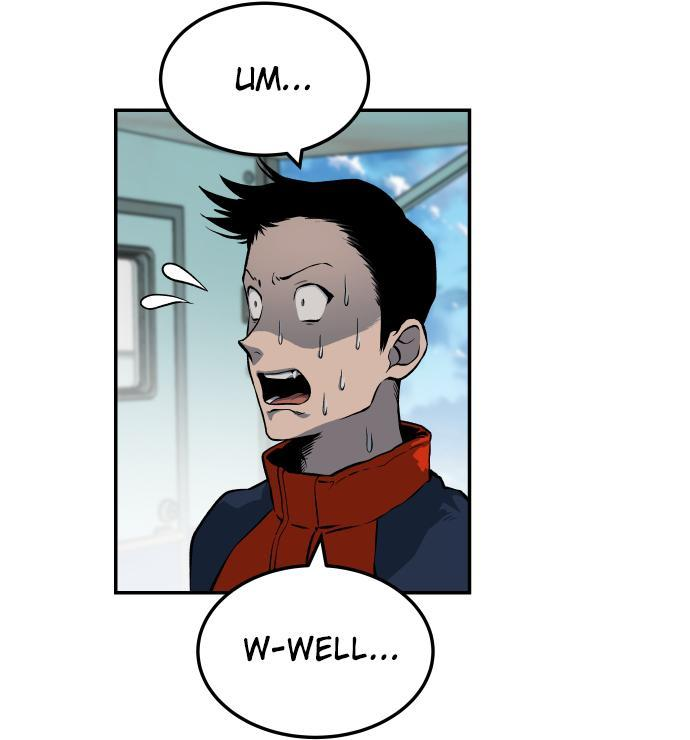

In [110]:
embs = encode_pil_image(images[0])

similar_images = similarity_search(embs[0], "ZOMGAN", 5)

point_to_image(similar_images[0])